In [1]:
from entsoe import EntsoePandasClient
import pandas as pd
from datetime import datetime, timedelta, timezone
import time
from pathlib import Path
import pytz
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

from keys import good_entsoe_keys

from update_entsoe import ALL_TAGS, TAGS_NON_RENEW, TAGS_RENEW
from update_entsoe import fetch_data_entsoe

# Manual Settings

In [2]:
country_code = 'DE'
country_code_prices = [
    # 'DE_AT_LU', # 2015 - 2018
    'DE_LU' # 2018 - 2024
] # Germany does not have its own bidding zone on ENTSO-E it would seem

# Load last updated data

In [13]:
files = glob(str(Path().absolute() / "data_updates" / (f"{country_code}_gen_load_daprice_upd_" + "*.csv")))
df_entsoe = pd.read_csv(files[0])

In [5]:
df_entsoe

,Lignite,Gas,Coal,Oil,Nuclear,Other,Waste,Biomass,Geothermal,Hydro_storage,...,Other_renew,Solar,Wind_off,Wind_on,Renewables,NonRenewables,Total,Actual Load,Day Ahead Price,dt_iso
0,12807.75,1100.50,3732.00,194.75,9711.50,223.25,584.75,3954.75,19.75,210.25,...,115.00,0.00,307.000000,4311.75,10828.750000,28354.5,39183.250000,41393.75,23.79,2015-05-01 00:00:00 +0000 UTC
1,12838.25,1100.00,3267.75,194.50,9688.00,220.25,584.25,3939.50,20.00,127.50,...,115.00,0.00,317.250000,4369.00,10783.250000,27893.0,38676.250000,40974.75,23.42,2015-05-01 01:00:00 +0000 UTC
2,12881.75,1084.75,3335.25,194.50,9695.75,213.50,589.50,3947.50,19.25,88.50,...,111.75,0.00,394.000000,4074.50,10557.250000,27995.0,38552.250000,41008.50,22.83,2015-05-01 02:00:00 +0000 UTC
3,12950.00,1043.00,3366.75,194.75,9650.50,193.75,588.75,3955.00,19.00,83.75,...,104.50,7.00,340.000000,3626.25,10060.250000,27987.5,38047.750000,40150.50,22.01,2015-05-01 03:00:00 +0000 UTC
4,12779.50,1054.50,3382.00,195.75,9655.75,187.50,580.50,3941.25,19.00,92.75,...,100.00,451.50,322.250000,3072.00,9917.000000,27835.5,37752.500000,38057.00,19.09,2015-05-01 04:00:00 +0000 UTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81725,7042.75,5434.75,2094.25,381.00,0.00,111.75,760.50,4173.00,21.00,5634.50,...,80.00,4019.50,4561.000000,6975.50,27508.750000,15825.0,43333.750000,55176.25,153.69,2024-08-26 05:00:00 +0000 UTC
81726,7051.50,4940.50,2034.75,381.00,0.00,111.00,751.75,4127.25,21.00,3958.25,...,80.00,11939.75,4694.500000,5827.25,32678.000000,15270.5,47948.500000,58841.75,130.97,2024-08-26 06:00:00 +0000 UTC
81727,6658.25,4231.50,1916.50,381.00,0.00,111.00,742.25,4109.00,21.00,956.50,...,80.00,20596.00,4342.250000,4508.25,36560.750000,14040.5,50601.250000,59805.25,98.93,2024-08-26 07:00:00 +0000 UTC
81728,5495.50,3330.50,1612.00,381.00,0.00,111.00,727.00,4111.75,21.00,141.50,...,80.00,28030.50,3622.500000,5345.50,43262.750000,11657.0,54919.750000,60188.25,77.00,2024-08-26 08:00:00 +0000 UTC


# Define Start and End times for the update

In [16]:
end = pd.Timestamp(datetime.now()).round(freq='h')
start = pd.to_datetime(df_entsoe['dt_iso'].to_list()[-5],format='%Y-%m-%d %H:%M:%S %z UTC')

end = end.replace(tzinfo=timezone.utc)
start = start.replace(tzinfo=timezone.utc)

diff = end - start
print(f"Start={start} end={end} (diff={diff})")
if diff.days < 1:
    print("\t ! Difference is less than 1 day. Update is not required")

Start=2024-08-28 11:00:00+00:00 end=2024-08-28 19:00:00+00:00 (diff=0 days 08:00:00)
	 ! Difference is less than 1 day. Update is not required


# Fetch data from ENTSO-E API for this time period

In [8]:
# How to aggregate data
df_upd = fetch_data_entsoe(start, end, country_code, country_code_prices, good_entsoe_keys[0])
df_upd

,Lignite,Gas,Coal,Oil,Nuclear,Other,Waste,Biomass,Geothermal,Hydro_storage,...,Other_renew,Solar,Wind_off,Wind_on,Renewables,NonRenewables,Total,Actual Load,Day Ahead Price,dt_iso
0,7042.75,5434.75,2094.25,381.00,0.0,111.75,760.50,4173.00,21.0,5634.50,...,80.00,4019.25,4561.00,6974.75,27507.75,15825.00,43332.75,55174.75,153.69,2024-08-26 05:00:00 +0000 UTC
1,7051.50,4940.50,2034.75,381.00,0.0,111.00,751.75,4127.25,21.0,3958.25,...,80.00,11653.50,4694.50,5830.00,32394.50,15270.50,47665.00,58846.25,130.97,2024-08-26 06:00:00 +0000 UTC
2,6658.25,4231.50,1916.50,381.00,0.0,111.00,742.25,4109.00,21.0,956.50,...,80.00,20250.75,4342.25,4511.75,36219.00,14040.50,50259.50,59787.50,98.93,2024-08-26 07:00:00 +0000 UTC
3,5495.50,3330.50,1612.00,381.00,0.0,111.00,727.00,4111.75,21.0,141.50,...,80.00,28009.75,3622.50,5342.00,43238.50,11657.00,54895.50,60196.75,77.00,2024-08-26 08:00:00 +0000 UTC
4,4396.50,3124.00,1908.25,381.00,0.0,111.00,745.75,4118.50,21.0,90.25,...,80.00,33084.25,1952.50,7061.00,48192.50,10666.50,58859.00,60367.25,65.31,2024-08-26 09:00:00 +0000 UTC
5,4101.00,2924.75,2014.50,381.00,0.0,111.00,743.25,4129.75,21.0,73.25,...,80.00,34495.50,1852.75,7960.25,50457.25,10275.50,60732.75,59899.75,23.07,2024-08-26 10:00:00 +0000 UTC
6,3917.75,2689.50,2157.00,498.75,0.0,111.00,745.50,4168.00,21.0,128.75,...,80.00,34009.50,1817.75,7543.00,49601.00,10119.50,59720.50,59015.00,17.55,2024-08-26 11:00:00 +0000 UTC
7,3897.00,2839.00,1925.75,814.50,0.0,111.00,748.00,4210.50,21.0,34.75,...,80.00,32104.25,1665.00,6919.50,46830.25,10335.25,57165.50,57533.75,42.88,2024-08-26 12:00:00 +0000 UTC
8,4308.00,3159.75,2364.50,498.25,0.0,111.75,747.00,4226.00,21.0,92.25,...,80.00,28377.00,2416.25,6067.00,43046.50,11189.25,54235.75,56605.00,71.05,2024-08-26 13:00:00 +0000 UTC
9,6002.75,3741.25,2454.75,381.00,0.0,113.75,742.00,4229.25,21.0,367.00,...,80.00,22709.25,2281.75,5125.75,36667.00,13435.50,50102.50,56092.25,88.00,2024-08-26 14:00:00 +0000 UTC


# Plot original and updated data 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


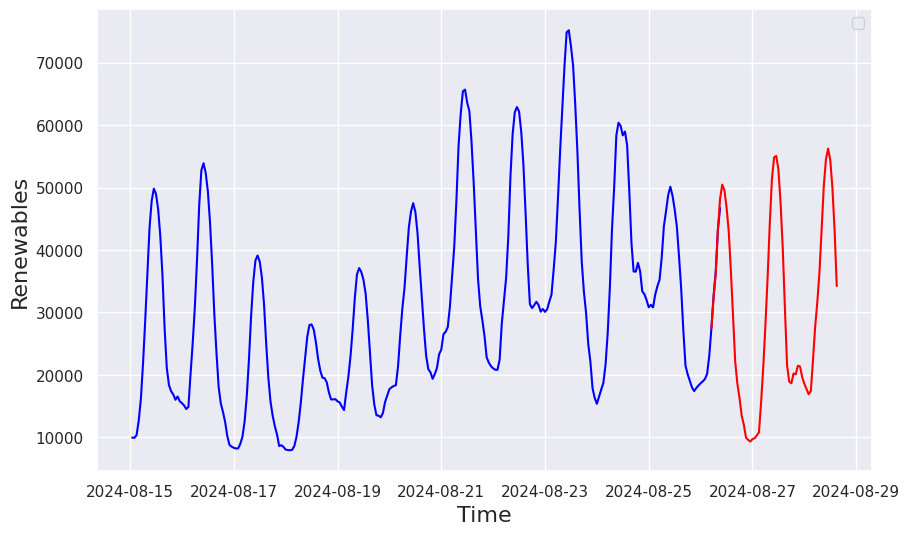

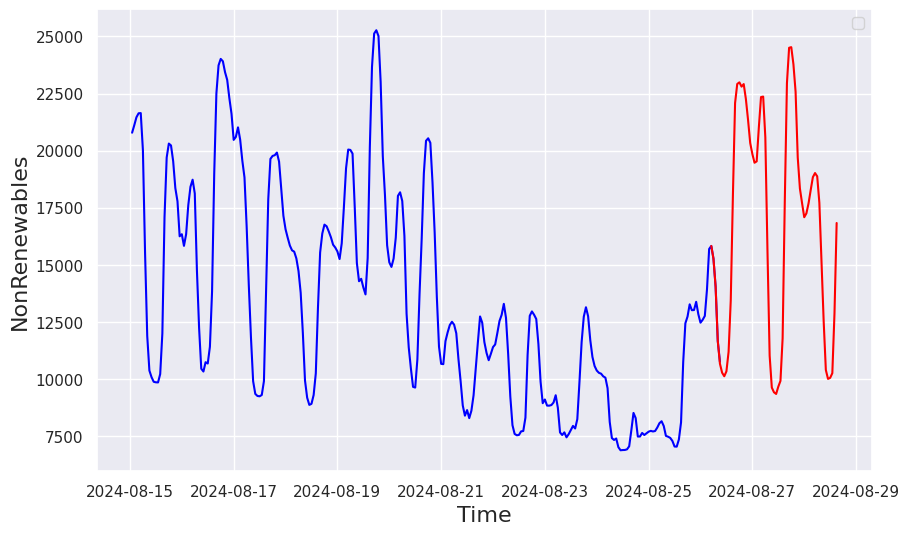

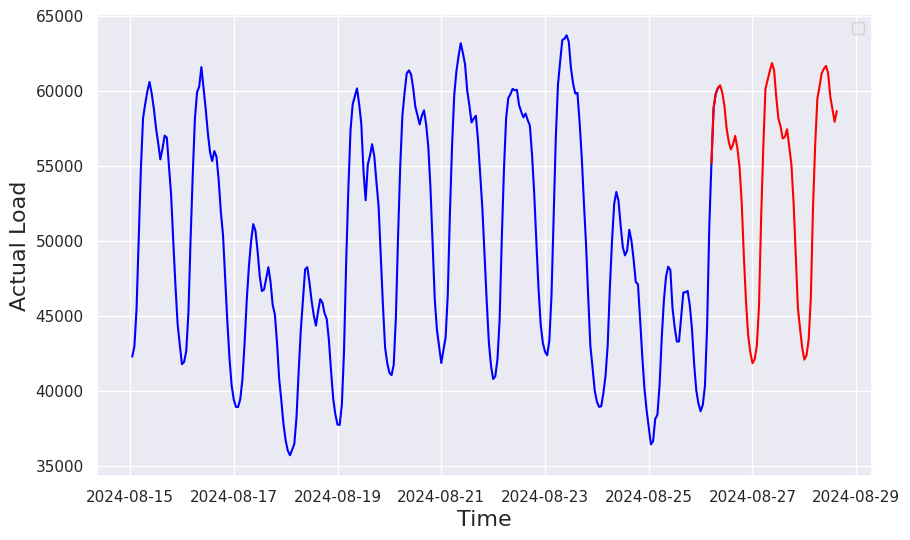

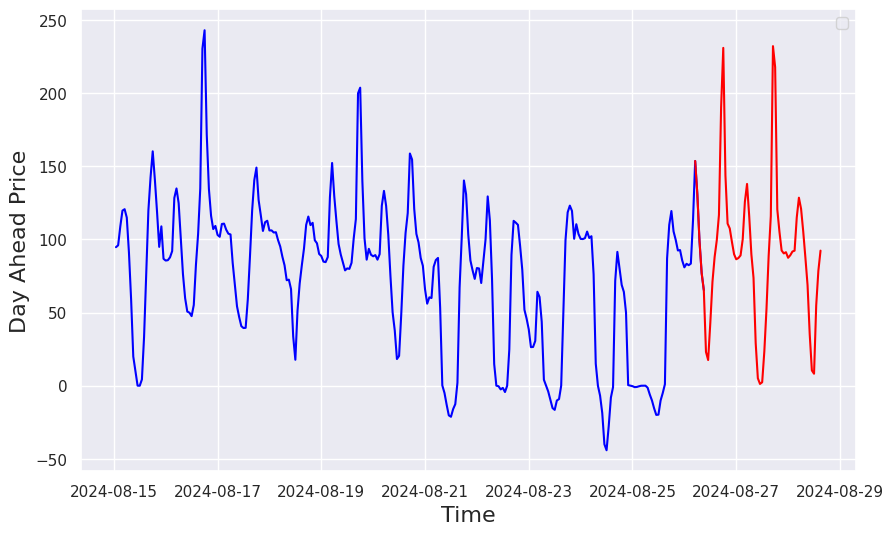

In [10]:
def plot_series(ax,df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None,color=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    if color is None: color = 'black'
    sns.set()
    if ax is None: fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label, color=color)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label, color=color)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

df_cp_entsoe = df_entsoe.copy(deep=True)
df_cp_upd = df_upd.copy(deep=True)

df_cp_entsoe.index = pd.to_datetime(df_cp_entsoe['dt_iso'],format='%Y-%m-%d %H:%M:%S %z UTC')
df_cp_upd.index = pd.to_datetime(df_cp_upd['dt_iso'],format='%Y-%m-%d %H:%M:%S %z UTC')
#df_upd2_cp.index = pd.to_datetime(df_upd2_cp['dt_iso'],format='%Y-%m-%d %H:%M:%S %z UTC')

for key in ['Renewables','NonRenewables','Actual Load', 'Day Ahead Price']:
    ax = plot_series(None,df_cp_entsoe,key,start=int(299*len(df_cp_entsoe)/300),color='blue',ylabel=key)
    plot_series(ax, df_cp_upd, key, color='red',ylabel=key)
    #plot_series(ax, df_upd2_cp, key, color='green',ylabel=key)
    # rolling = df_weather[key].rolling(window=4*24*7, center=True).mean()
    # rolling = df_upd[key].rolling(window=4*24*7, center=True).mean()
    # ax.plot(rolling, linestyle='-', linewidth=2, label=f'Weekly rolling {key}')
    # ax.plot(rolling, linestyle='-', linewidth=2, label=f'Weekly rolling {key}')
    ax.legend()
plt.show()

# Append retrieved data and save

In [12]:
df_entsoe_upd = pd.concat([df_entsoe, df_upd], ignore_index=True)

# remove duplicated timestaps
df_entsoe_upd.drop_duplicates(subset=['dt_iso'], inplace=True)

timestr=time.strftime("%Y%m%d")
df_entsoe_upd.to_csv(Path().absolute() / 'data_updates' / f"{country_code}_gen_load_daprice_upd_{timestr}.csv",index=False)